# Getting the most solar power for your dollar
## Data wrangling
### Zachary Brown

The goal of this project is to use the Tracking the Sun dataset from the Lawrence Berkeley National Laboratory to create a model that identifies what factors make residential solar panel installations in Austin, Texas as cost-efficient as possible. To do so the data will be loaded from Parquet files and in this notebook will be wrangled into the working dataframe for the rest of the project.

I'll start off by importing the modules needed for importing and wrangling the data.

In [2]:
import os
import urllib.request
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime

Next I need to download the Parquet datafiles into the external data directory within this repository, so I'll switch to the correct directory.

In [3]:
print(os.getcwd())
os.chdir(r"..\data\external")
data_dir = os.getcwd()
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\external


The next step is to download the parquet files. The entire collection of data is hosted here: https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F

I only need 2021 data for this project as I want the most up to date model possible. Within 2021 the data is broken down by state. I need to download all 26 files, so I'll create a function to automatically download them all for me.

In [4]:
# Start by creating the function and creating empty url and file name lists

def import_data(root_url):
    urls = []
    file_names = []
    
# Parse the 2021 data directory to get URLs for each state    

    response = requests.get(root_url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    for a in soup.find_all('a', href=True):
        if '/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F' in a['href']:
            urls.append('https://data.openei.org' + a['href'])
    
# Create a list of the file names for each state from each link in the urls list

    for url in urls:
        url_response = requests.get(url)
        url_soup = BeautifulSoup(url_response.content, 'html.parser')
        
        for a in url_soup.find_all('a', href=True):
            if '.parquet' in a['href']:
                file_names.append(a['href'])
            
# Loop through each file and download to data directory

    for url, file in zip(urls, file_names):
        urllib.request.urlretrieve(file, url[97:99] + '.parquet')

Now that the function has been created to download all of the Parquet files locally we need to run it with the 2021 URL to download the state data files.

In [5]:
import_data('https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F2021%2F')

Now the data files need to be loaded into a single Pandas dataframe to begin the wrangling process.

In [6]:
file_list = []

# I'll start by adding each Parquet file to an empty list.
for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_list.append(file)
        
# Now I'll iterate over the file_list and read each in to one dataframe, aggregating all of the data.
tables = []

for filename in file_list:
    df = pd.read_parquet(filename)
    df['state'] = filename[0:2]
    tables.append(df)

raw_data = pd.concat(tables, ignore_index=True)
raw_data.head()

,data_provider_1,data_provider_2,system_id_1,system_id_2,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,output_capacity_inverter_2,output_capacity_inverter_3,dc_optimizer,inverter_loading_ratio,date_of_battery_install,battery_manufacturer,battery_model,battery_rated_capacity_kw,battery_rated_capacity_kwh,state
0,Arkansas State Energy Office,-1,-1,-1,2010-04-29,2.016,14558.0,0.0,RES,0,...,-1.0,-1.0,0,1.178947,NaT,-1,-1,-1.0,-1.0,AR
1,Arkansas State Energy Office,-1,-1,-1,2010-04-26,3.360,26096.0,0.0,RES,0,...,-1.0,-1.0,0,1.178947,NaT,-1,-1,-1.0,-1.0,AR
2,Arkansas State Energy Office,-1,-1,-1,2010-04-20,13.440,91139.0,0.0,RES,0,...,-1.0,-1.0,0,1.178947,NaT,-1,-1,-1.0,-1.0,AR
3,Arkansas State Energy Office,-1,-1,-1,2010-04-21,5.520,40043.0,0.0,RES,0,...,-1.0,-1.0,0,1.210526,NaT,-1,-1,-1.0,-1.0,AR
4,Arkansas State Energy Office,-1,-1,-1,2010-04-22,2.530,21497.0,0.0,RES,0,...,-1.0,-1.0,0,1.210526,NaT,-1,-1,-1.0,-1.0,AR


Ok, now that the dataframe has been assembled it's time to explore it.

In [7]:
raw_data.shape

(2041551, 81)

In [8]:
raw_data.columns

Index(['data_provider_1', 'data_provider_2', 'system_id_1', 'system_id_2',
       'installation_date', 'system_size_dc', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'azimuth_2', 'azimuth_3', 'tilt_1', 'tilt_2', 'tilt_3',
       'module_manufacturer_1', 'module_model_1', 'module_quantity_1',
       'module_manufacturer_2', 'module_model_2', 'module_quantity_2',
       'module_manufacturer_3', 'module_model_3', 'module_quantity_3',
       'additional_modules', 'technology_module_1', 'technology_module_2',
       'technology_module_3', 'bipv_module_1', 'bipv_module_2',
       'bipv_module_3', 'bifacial_module_1', 'bifacial_module_2',
       'bifacial_module_3', 'nameplate_capacity_module_1',
       'nameplate_capacity_module

In [9]:
col = raw_data.columns.to_series().groupby(df.dtypes).groups
print(col)

{datetime64[ns]: ['installation_date', 'date_of_battery_install'], int32: ['expansion_system', 'multiple_phase_system', 'new_construction', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'module_quantity_2', 'module_quantity_3', 'additional_modules', 'bipv_module_1', 'bipv_module_2', 'bipv_module_3', 'bifacial_module_1', 'bifacial_module_2', 'bifacial_module_3', 'nameplate_capacity_module_1', 'nameplate_capacity_module_2', 'nameplate_capacity_module_3', 'inverter_quantity_1', 'inverter_quantity_2', 'inverter_quantity_3', 'additional_inverters', 'micro_inverter_1', 'micro_inverter_2', 'micro_inverter_3', 'solar_storage_hybrid_inverter_1', 'solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3', 'built_in_meter_inverter_1', 'built_in_meter_inverter_2', 'built_in_meter_inverter_3', 'output_capacity_inverter_1', 'output_capacity_inverter_2', 'output_capacity_inverter_3', 'dc_optimizer'], float64: ['system_size_dc', 'total_installed_pr

Right now zip code is object type when it seems like it should be an integer. I'll check to see if any zip codes are longer than the expected 5 digits.

In [10]:
long_zip = raw_data[raw_data['zip_code'].str.len() > 5]
long_zip['zip_code'].head()

118255    85040-2753
118256    85119-3855
118258    85204-3816
118259    85209-1428
118267    85143-5600
Name: zip_code, dtype: object

Ok, so it's an object because it includes 9-digit zip codes. That's fine, I'll leave it unchanged for now. 

Before I create a state column I'll pare down the data to only applicable rows. This means just residential installations from 2021 that are not missing 'total_installed_price' values

In [11]:
print(raw_data['customer_segment'].unique())

['RES' 'NON-PROFIT' 'COM' 'GOV' 'NON-RES' 'SCHOOL' '-1']


In [12]:
# Now I'll subset the data to just residential installations
res_data = raw_data[raw_data['customer_segment'] == 'RES']
res_data.shape

(1948072, 81)

In [13]:
res_copy = res_data.copy()
res_copy['year'] = res_copy.installation_date.dt.year
res_copy['year'].value_counts().sort_index()

1971.0         1
1985.0         3
1986.0         6
1988.0         5
1989.0         5
1990.0         6
1991.0        10
1992.0         8
1993.0         4
1994.0         7
1995.0        10
1996.0         8
1997.0        12
1998.0        32
1999.0       170
2000.0       175
2001.0      1139
2002.0      2181
2003.0      2818
2004.0      4956
2005.0      5052
2006.0      8309
2007.0     12497
2008.0     14394
2009.0     26267
2010.0     36691
2011.0     47583
2012.0     66465
2013.0    103238
2014.0    154819
2015.0    245536
2016.0    278337
2017.0    218597
2018.0    223471
2019.0    240816
2020.0    238227
2021.0      2266
2106.0         8
Name: year, dtype: int64

Interestingly it looks like there's not actually very much 2021 data in the Parquet files, so I'll use 2020 and 2021 data together to build the model for this project. 

In [22]:
newest_data = res_copy.loc[res_copy['installation_date'].dt.year.isin([2020, 2021])]
newest_data.shape

(240493, 82)

Next, while I'm working with the dates, I'll break out the month into a separate column since that will probably be the most useful date grouping for modeling.

In [25]:
date_data = newest_data.copy()
date_data['month'] = date_data['installation_date'].dt.month
date_data['month'].value_counts().sort_index()

1     23717
2     20453
3     21856
4     17732
5     14392
6     16886
7     21173
8     18170
9     19285
10    21158
11    19503
12    26168
Name: month, dtype: int64

Next I want to check how many rows are missing 'total_installed_price' data and remove them since that price is key to calculating the final installed price, which is the key metric for the model. Missing values are indicated as -1 in this dataset.

In [29]:
date_data['total_installed_price'].value_counts().sort_index()

-1.00          32029
 0.01              8
 0.10              1
 1.00           1937
 3.25              9
               ...  
 3680000.00        1
 4789800.00        1
 7485834.00        1
 8255000.00        1
 9887777.00        1
Name: total_installed_price, Length: 78725, dtype: int64

While I don't believe that any solar panel installations actually cost \\$0.01, \\$0.10, or \\$1.00, I don't know for sure why they're in there, so I'll check a plot to see if there's an obvious divide between erroneous values and realistic ones. Since price will most likely be linked to 'module_quantity_1' I'll create a scatterplot and look for low price points that appear to be outliers.

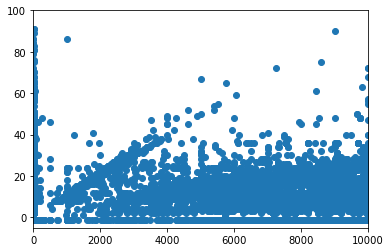

In [30]:
plt.scatter(date_data['total_installed_price'],date_data['module_quantity_1'])
plt.xlim(-5, 10000)
plt.ylim([-5,100])
plt.show()

As crowded as this plot is, there is an obvious linear correlation in there, and there is also so much variation that there is no easy way to tell what can be considered an outlier at low price points. I'll just remove rows with missing (-1) values in 'total_installed_price' for now.

In [35]:
missing_sale = date_data['total_installed_price'] == -1
date_data = date_data[~missing_sale]
date_data.shape

(208464, 83)

Now to complete the final price calculation I'll need to recode the missing values in 'rebate_or_grant' from -1 to 0 so they're not affecting the installation price.

In [36]:
print(date_data['rebate_or_grant'].min())
date_data['rebate_or_grant'] = newest_data['rebate_or_grant'].replace(-1, 0)
print(date_data['rebate_or_grant'].min())

0.0
0.0


Now I'll calculate the 'final_installed_price', which will be the field being modeled, by subtracting any rebates or grants from the total installed price.

In [38]:
date_data['final_installed_price'] = date_data['total_installed_price'] - date_data['rebate_or_grant']
date_data.loc[date_data['rebate_or_grant'] != 0.0][['total_installed_price', 'rebate_or_grant', 'final_installed_price']]

,total_installed_price,rebate_or_grant,final_installed_price
189868,28000.0,476.0,27524.0
189874,55260.0,1020.0,54240.0
189879,22440.0,408.0,22032.0
189883,37394.0,449.5,36944.5
189894,20738.5,351.5,20387.0
...,...,...,...
2041546,34452.0,500.0,33952.0
2041547,43152.0,500.0,42652.0
2041548,25583.0,500.0,25083.0
2041549,70909.0,1000.0,69909.0


Now I want to check the proportion of each column that is missing data. I may be able to remove some columns if they are mostly missing values that will skew the model. I'll start with the object columns, then move to integer columns.

In [39]:
object_missing = (date_data[date_data == '-1'].count() / date_data.count() * 100).sort_values(ascending=False).to_string()
print(object_missing)

inverter_manufacturer_2            100.000000
inverter_model_2                   100.000000
inverter_manufacturer_3            100.000000
inverter_model_3                   100.000000
technology_module_3                 97.781871
module_manufacturer_3               97.781392
module_model_3                      97.781392
system_id_2                         95.007291
data_provider_2                     94.978030
battery_model                       94.514640
battery_manufacturer                94.271433
technology_module_2                 93.726495
module_model_2                      93.712583
module_manufacturer_2               93.712583
inverter_manufacturer_1             11.681633
inverter_model_1                    11.681154
technology_module_1                 10.684339
module_manufacturer_1               10.683859
module_model_1                      10.683859
city                                 8.493553
zip_code                             5.932439
system_id_1                       

In [40]:
int_missing = (date_data[newest_data == -1].count() / date_data.count() * 100).sort_values(ascending=False).to_string()
print(int_missing)

output_capacity_inverter_3         99.968298
inverter_quantity_3                99.952510
solar_storage_hybrid_inverter_3    99.865684
micro_inverter_3                   99.834504
built_in_meter_inverter_3          99.834504
output_capacity_inverter_2         99.833291
inverter_quantity_2                98.866951
solar_storage_hybrid_inverter_2    98.795475
micro_inverter_2                   98.743668
built_in_meter_inverter_2          98.743668
tilt_3                             98.074008
azimuth_3                          98.074008
module_quantity_3                  97.879250
efficiency_module_3                97.797701
nameplate_capacity_module_3        97.784686
bipv_module_3                      97.782831
bifacial_module_3                  97.781871
new_construction                   95.320535
tilt_2                             94.972753
azimuth_2                          94.972753
battery_rated_capacity_kwh         94.037340
module_quantity_2                  93.873762
efficiency

There are four columns that are 100% missing data, so I'll remove them now and then look through a Pandas Profiling report to check the other mostly-missing columns for any correlation to the price that might be worth keeping them in.

In [68]:
empty_objs = (date_data[date_data == '-1'].count() / date_data.count() * 100) > 75
red_data = date_data[date_data.columns[~empty_objs]]
empty_ints = (red_data[red_data == -1].count() / red_data.count() * 100) > 75
reduced_data = red_data[red_data.columns[~empty_ints]]
reduced_data.shape

(208464, 42)

In [69]:
reduced_data.columns

Index(['data_provider_1', 'system_id_1', 'installation_date', 'system_size_dc',
       'total_installed_price', 'rebate_or_grant', 'customer_segment',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'additional_modules', 'technology_module_1',
       'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1',
       'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1',
       'dc_optimizer', 'inverter_loading_ratio', 'date_of_battery_install',
       'state', 'year', 'month', 'final_installed_price'],
      dtype='object')

Since my goal is to model the factors that improve cost efficiency in Austin, TX specifically I want to create two dummy columns, one for whether the entry is in Austin, and one for whether the entry is in Texas. First I'll confirm that I have entries fulfilling both of those criteria.

In [70]:
reduced_data['city'].loc[reduced_data['state'] == 'TX'].value_counts()

San Antonio        4476
-1                 1103
Laredo               10
San Angelo            8
Corpus Christi        5
McAllen               4
Abilene               4
Marfa                 3
Alpine                3
Tuscola               2
Port Aransas          2
Mission               2
Rockport              2
Edinburg              2
Corpus christi        2
Bay City              1
Roma                  1
Rio Grande City       1
Kingsville            1
Jourdanton            1
Pharr                 1
Alamo                 1
Merkel                1
Fort Davis            1
Christoval            1
San Juan              1
Weslaco               1
Name: city, dtype: int64

Ok, unfortunately I don't have data for Austin TX and roughly 20% of the data doesn't have a city listed, so I'll generalize the project goal to just modeling the state of Texas instead. Now I'll make that dummy column

In [84]:
tx_data = reduced_data.copy()
tx_data['is_TX'] = (tx_data['state'] == 'TX') * 1
tx_data['is_TX'].value_counts()

0    202824
1      5640
Name: is_TX, dtype: int64

In [53]:
# Export data
#print(os.getcwd())
#os.chdir(r"..\data\interim")
#print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\external


In [ ]:
#reduced_data.to_csv('wrangled_data.csv')